## &#x1F310; &nbsp; Code Library, Style, and Links
The previous notebooks:

&#x1F4D8; &nbsp;  [PASSNYC. Data Exploration](https://www.kaggle.com/olgabelitskaya/passnyc-data-exploration)

&#x1F4D8; &nbsp;  [PASSNYC. Numeric and Categorical Variables](https://www.kaggle.com/olgabelitskaya/passnyc-numeric-and-categorical-variables)

In [2]:
%%html
<style> 
@import url('https://fonts.googleapis.com/css?family=Orbitron|Roboto');
body {background-color: gainsboro;} 
a {color: #37c9e1; font-family: 'Roboto';} 
h1 {color: #37c9e1; font-family: 'Orbitron'; text-shadow: 4px 4px 4px #aaa;} 
h2, h3 {color: slategray; font-family: 'Orbitron'; text-shadow: 4px 4px 4px #aaa;}
h4 {color: #37c9e1; font-family: 'Roboto';}
span {text-shadow: 4px 4px 4px #aaa;}
div.output_prompt, div.output_area pre {color: slategray;}
div.input_prompt, div.output_subarea {color: #37c9e1;}      
div.output_stderr pre {background-color: gainsboro;}  
div.output_stderr {background-color: slategrey;}               
</style>

In [3]:
import numpy as np 
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from descartes import PolygonPatch

from IPython.display import HTML
from sklearn.preprocessing import minmax_scale

In [4]:
style_dict = {'background-color':'slategray',
              'color':'#37c9e1',
              'border-color': 'white'}
# df.style.set_properties(**style_dict)

## &#x1F310; &nbsp; Load and Preprocess the Data

In [5]:
school_explorer = pd.read_csv('2016 School Explorer.csv')
d5_shsat = pd.read_csv('D5 SHSAT Registrations and Testers.csv')
sat_2010 = pd.read_csv('2010-sat-college-board-school-level-results.csv')
ap_2010 = pd.read_csv('2010-ap-college-board-school-level-results.csv')
sat_2012 = pd.read_csv('2012-sat-results.csv')
school_explorer.shape, d5_shsat.shape, sat_2010.shape, ap_2010.shape, sat_2012.shape

((1272, 161), (140, 7), (460, 6), (258, 5), (478, 6))

In [6]:
sat_2010.head().style.set_properties(**style_dict)

,DBN,School Name,Number of Test Takers,Critical Reading Mean,Mathematics Mean,Writing Mean
0,01M292,Henry Street School for International Studies,31,391,425,385
1,01M448,University Neighborhood High School,60,394,419,387
2,01M450,East Side Community High School,69,418,431,402
3,01M458,SATELLITE ACADEMY FORSYTH ST,26,385,370,378
4,01M509,CMSP HIGH SCHOOL,nan,nan,nan,nan


In [7]:
ap_2010.head().style.set_properties(**style_dict)

,DBN,SchoolName,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5
0,01M448,UNIVERSITY NEIGHBORHOOD H.S.,39,49,10
1,01M450,EAST SIDE COMMUNITY HS,19,21,nan
2,01M515,LOWER EASTSIDE PREP,24,26,24
3,01M539,"NEW EXPLORATIONS SCI,TECH,MATH",255,377,191
4,02M296,High School of Hospitality Management,nan,nan,nan


In [8]:
sat_2012.head().style.set_properties(**style_dict)

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355,404,363
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383,423,366
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377,402,370
3,01M458,FORSYTH SATELLITE ACADEMY,7,414,401,359
4,01M509,MARTA VALLE HIGH SCHOOL,44,390,433,384


In [9]:
# Fillna or replace values
numeric_list = list(school_explorer\
.columns[[7,8]+list(range(16,27))+[28,30,32,34,36]+list(range(41,161))])
target_list = ['Average ELA Proficiency','Average Math Proficiency']

school_explorer = school_explorer.drop(['Adjusted Grade',
                                        'New?',
                                        'Other Location Code in LCGMS'], 
                                       axis=1)
school_explorer.loc[[427,1023,712,908],'School Name'] = \
['P.S. 212 D12','P.S. 212 D30','P.S. 253 D21','P.S. 253 D27']

percent_list = ['Percent ELL','Percent Asian','Percent Black',
                'Percent Hispanic','Percent Black / Hispanic',
                'Percent White','Student Attendance Rate',
                'Percent of Students Chronically Absent',
                'Rigorous Instruction %','Collaborative Teachers %',
                'Supportive Environment %','Effective School Leadership %',
                'Strong Family-Community Ties %','Trust %']

for el in percent_list:
    school_explorer[el] = school_explorer[el].astype('str')
    school_explorer[el] = school_explorer[el].str.replace("%", "")
    school_explorer[el] = school_explorer[el].str.replace("nan", "0")
    school_explorer[el] = school_explorer[el].astype(float)
    school_explorer[el].replace(0, np.NaN, inplace=True)
    school_explorer[el] = school_explorer[el].interpolate()
    
school_explorer['Economic Need Index'] = \
school_explorer['Economic Need Index'].interpolate()
school_explorer['Average ELA Proficiency'] = \
school_explorer['Average ELA Proficiency'].interpolate()
school_explorer['Average Math Proficiency'] = \
school_explorer['Average Math Proficiency'].interpolate()

school_explorer['School Income Estimate'] = \
school_explorer['School Income Estimate'].astype('str') 
for s in [",","$"," "]:
    school_explorer['School Income Estimate'] = \
    school_explorer['School Income Estimate'].str.replace(s, "")
school_explorer['School Income Estimate'] = \
school_explorer['School Income Estimate'].str.replace("nan", "0")

school_explorer['School Income Estimate'] = \
school_explorer['School Income Estimate'].astype(float)
school_explorer['School Income Estimate'].replace(0, np.NaN, inplace=True)
school_explorer['School Income Estimate'] = \
school_explorer['School Income Estimate'].interpolate()

rating_list = ['Rigorous Instruction Rating','Collaborative Teachers Rating',
               'Supportive Environment Rating','Effective School Leadership Rating',
               'Strong Family-Community Ties Rating','Strong Family-Community Ties Rating',
               'Trust Rating','Student Achievement Rating']

for el in rating_list:
    moda_value = school_explorer[el].value_counts().idxmax()
    school_explorer[el] = school_explorer[el].fillna(moda_value) 
    
category_list1 = ['District','Community School?','City','Grades']
                  
category_list2 = ['Rigorous Instruction Rating',
                  'Collaborative Teachers Rating',
                  'Supportive Environment Rating',
                  'Effective School Leadership Rating',
                  'Strong Family-Community Ties Rating',
                  'Trust Rating','Student Achievement Rating']

for feature in category_list1:
    feature_cat = pd.factorize(school_explorer[feature])
    school_explorer[feature] = feature_cat[0]
    
for feature in category_list2:
    feature_pairs = dict(zip(['Not Meeting Target', 'Meeting Target', 
                              'Approaching Target', 'Exceeding Target'],
                             ['0','2','1','3']))
    school_explorer[feature].replace(feature_pairs,inplace=True)
    school_explorer[feature] = school_explorer[feature].astype(int)
    
category_list = list(category_list1+category_list2)
    
print('NaN count = ', sum(school_explorer.isna().sum()))    

NaN count =  0


In [10]:
d5_shsat_2016 = d5_shsat[['DBN',
                          'Number of students who registered for the SHSAT',
                          'Number of students who took the SHSAT']]\
[d5_shsat['Year of SHST']==2016]\
.groupby(['DBN'],as_index=False).agg(np.sum)

d5_shsat_2016['Took SHSAT %'] = \
d5_shsat_2016['Number of students who took the SHSAT']\
/d5_shsat_2016['Number of students who registered for the SHSAT']

d5_shsat_2016['Took SHSAT %'] = \
d5_shsat_2016['Took SHSAT %'].fillna(0).apply(lambda x: round(x,3))
d5_shsat_2016.rename(columns={'DBN':'Location Code'}, inplace=True)

d5_shsat_2016 = pd.merge(school_explorer[['Location Code']+numeric_list+target_list],
                         d5_shsat_2016, 
                         on='Location Code')

d5_shsat_2016.shape

(21, 144)

In [11]:
geo_districts = gpd.GeoDataFrame.from_file("nysd.shp") # EPSG:2263
geo_districts = geo_districts.to_crs(epsg=4326).sort_values('SchoolDist')

geo_districts = geo_districts.reset_index(drop=True)

districts = school_explorer[numeric_list+['Average ELA Proficiency','Average Math Proficiency']]\
.groupby(school_explorer['District']).mean().sort_values('District')
districts = districts.append(districts.loc[9]).sort_values('District')
districts = districts.reset_index(drop=True)
districts = pd.concat([geo_districts, districts], axis=1)

districts.shape

(33, 144)

In [12]:
sat_2010.rename(columns={'DBN':'Location Code'}, inplace=True)
ap_2010.rename(columns={'DBN':'Location Code'}, inplace=True)
sat_2012.rename(columns={'DBN':'Location Code'}, inplace=True)

res_2010 = pd.merge(ap_2010, sat_2010, on='Location Code').dropna()
res_2010 = res_2010.drop(['SchoolName'], axis=1)

re_dict = {'AP Test Takers ':'AP Test Takers 2010',
           'Number of Test Takers':'Number of Test Takers 2010',
           'Critical Reading Mean':'Critical Reading Mean 2010',
           'Mathematics Mean':'Mathematics Mean 2010',
           'Writing Mean':'Writing Mean 2010'} 

res_2010.rename(columns=re_dict, inplace=True)

res_2010['AP Exam Ratio 2010'] = \
res_2010['Number of Exams with scores 3 4 or 5'] / res_2010['Total Exams Taken']

res_2010 = res_2010.drop(['Total Exams Taken'], axis=1)
res_2010 = res_2010.drop(['Number of Exams with scores 3 4 or 5'], axis=1)

res_2010_2012 = pd.merge(res_2010, sat_2012, on='Location Code').dropna()
res_2010_2012 = res_2010_2012.drop(['School Name'], axis=1)

re_dict = {'Num of SAT Test Takers':'Num of SAT Test Takers 2012',
           'SAT Critical Reading Avg. Score':'SAT Critical Reading Avg. Score 2012',
           'SAT Math Avg. Score':'SAT Math Avg. Score 2012',
           'SAT Writing Avg. Score':'SAT Writing Avg. Score 2012'}

res_2010_2012.rename(columns=re_dict, inplace=True)

tend_list = ['SAT Critical Reading Avg. Score 2012',
             'SAT Math Avg. Score 2012',
             'SAT Writing Avg. Score 2012']

for s in tend_list:
    res_2010_2012[s] = res_2010_2012[s].astype(float)
    
res_2010_2012_2016 = \
pd.merge(school_explorer[['Location Code','District','City',
                          'Longitude','Latitude',
                          'Average ELA Proficiency',
                          'Average Math Proficiency']],
         res_2010_2012, 
         on='Location Code').dropna() 

re_dict = {'Average ELA Proficiency':'Average ELA Proficiency 2016',
           'Average Math Proficiency':'Average Math Proficiency 2016'}

res_2010_2012_2016.rename(columns=re_dict, inplace=True)

norm_res_2010_2012_2016 = \
pd.DataFrame(minmax_scale(res_2010_2012_2016.iloc[:,[5,6,9,10,11,12,15,16,17]]),
             columns=list(res_2010_2012_2016.columns[[5,6,9,10,11,12,15,16,17]]))

res_2010.shape, res_2010_2012.shape, res_2010_2012_2016.shape

((148, 8), (148, 12), (22, 18))

In [13]:
res_2010_2012_2016.head().T.style.set_properties(**style_dict)

,0,1,2,3,4
Location Code,01M539,02M408,02M655,04M610,05M499
District,0,1,1,3,4
City,0,0,0,0,0
Longitude,-73.9792,-73.9887,-73.9459,-73.9472,-73.9365
Latitude,40.7195,40.7613,40.7833,40.7929,40.8244
Average ELA Proficiency 2016,3.83,3.44,2.24,2.69,2.41
Average Math Proficiency 2016,4.03,3.38,1.95,2.54,2.24
AP Test Takers 2010,255,20,50,41,163
Number of Test Takers 2010,47,69,71,48,216
Critical Reading Mean 2010,568,495,399,451,465


## &#x1F310; &nbsp; Educational Data Visualization
#### Average Math & ELA Proficiency

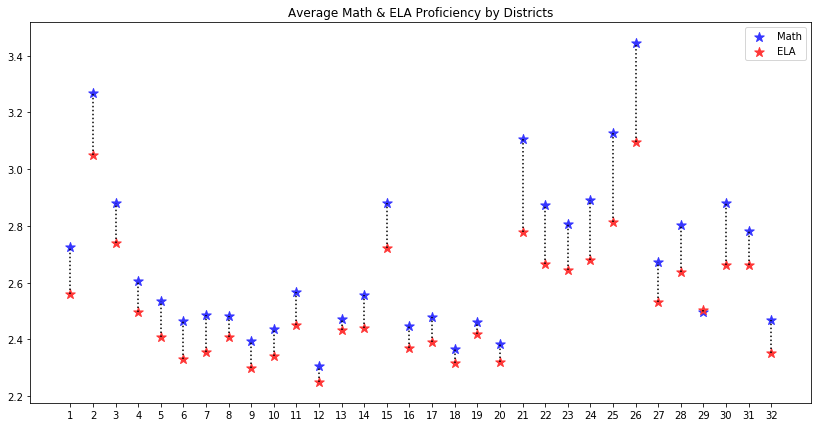

In [14]:
fig,ax = plt.subplots(1, figsize=(14,7))
avg_maths = districts['Average Math Proficiency'].drop([10])
avg_ela = districts['Average ELA Proficiency'].drop([10])

ax.scatter(range(1,33),avg_maths,marker='*',s=100,label='Math',c='#3636ff')
ax.scatter(range(1,33),avg_ela,marker='*',s=100,label='ELA',c='#ff3636')
plt.vlines(range(1,33),avg_ela,avg_maths,linestyle="dotted")
ax.legend()
ax.set_xticks(list(range(1,33)))
plt.title('Average Math & ELA Proficiency by Districts');

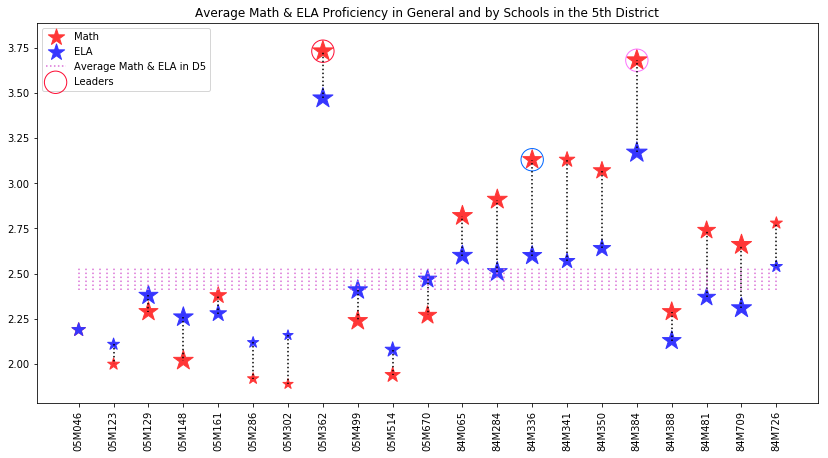

In [28]:
fig,ax = plt.subplots(1, figsize=(14,7))
avg_maths2 = d5_shsat_2016['Average Math Proficiency']
avg_ela2 = d5_shsat_2016['Average ELA Proficiency']
took = d5_shsat_2016['Took SHSAT %']

ax.scatter(range(1,22),avg_maths2,marker='*',s=took*500,label='Math',c='#ff3636')
ax.scatter(range(1,22),avg_ela2,marker='*',s=took*500,label='ELA',c='#3636ff')
plt.vlines(range(1,22),avg_ela2,avg_maths2,linestyle="dotted")
plt.vlines(np.arange(1.0,21.2,0.2),avg_ela[4],avg_maths[4],
           colors='orchid',linestyle="dotted",
           label='Average Math & ELA in D5')

ax.scatter([8,14,17],avg_maths2[[7,13,16]],label='Leaders',
           s=500,facecolors='none',edgecolors=['#fd0e35','#0066ff','#fc74fd'])
ax.legend(loc=2)
ax.set_xticks(range(1,22))
ax.set_xticklabels(list(d5_shsat_2016['Location Code']),
                   rotation=90)
plt.title('Average Math & ELA Proficiency in General and by Schools in the 5th District');

On this graph, we can see two absolute leaders in educational results. The third place was marked also.

The size of the marker on the graph corresponds to the ratio of students who took the SHSAT to those who registered for the SHSAT.

These leaders have very good results in this ratio too.

#### Math & ELA 4s Ratio by Grades

In [17]:
ela4s_ratio = pd.DataFrame({
    'Grade 3': districts.iloc[:,23].drop([10])/ districts.iloc[:,22].drop([10]),
    'Grade 4': districts.iloc[:,43].drop([10])/ districts.iloc[:,42].drop([10]),
    'Grade 5': districts.iloc[:,63].drop([10])/ districts.iloc[:,62].drop([10]),
    'Grade 6': districts.iloc[:,83].drop([10])/ districts.iloc[:,82].drop([10]),
    'Grade 7': districts.iloc[:,103].drop([10])/ districts.iloc[:,102].drop([10]),
    'Grade 8': districts.iloc[:,123].drop([10])/ districts.iloc[:,122].drop([10])
})
math4s_ratio = pd.DataFrame({
    'Grade 3': districts.iloc[:,33].drop([10])/ districts.iloc[:,32].drop([10]),
    'Grade 4': districts.iloc[:,53].drop([10])/ districts.iloc[:,52].drop([10]),
    'Grade 5': districts.iloc[:,73].drop([10])/ districts.iloc[:,72].drop([10]),
    'Grade 6': districts.iloc[:,93].drop([10])/ districts.iloc[:,92].drop([10]),
    'Grade 7': districts.iloc[:,113].drop([10])/ districts.iloc[:,112].drop([10]),
    'Grade 8': districts.iloc[:,133].drop([10])/ districts.iloc[:,132].drop([10])
})
ela4s_ratio.shape; math4s_ratio.shape

(32, 6)

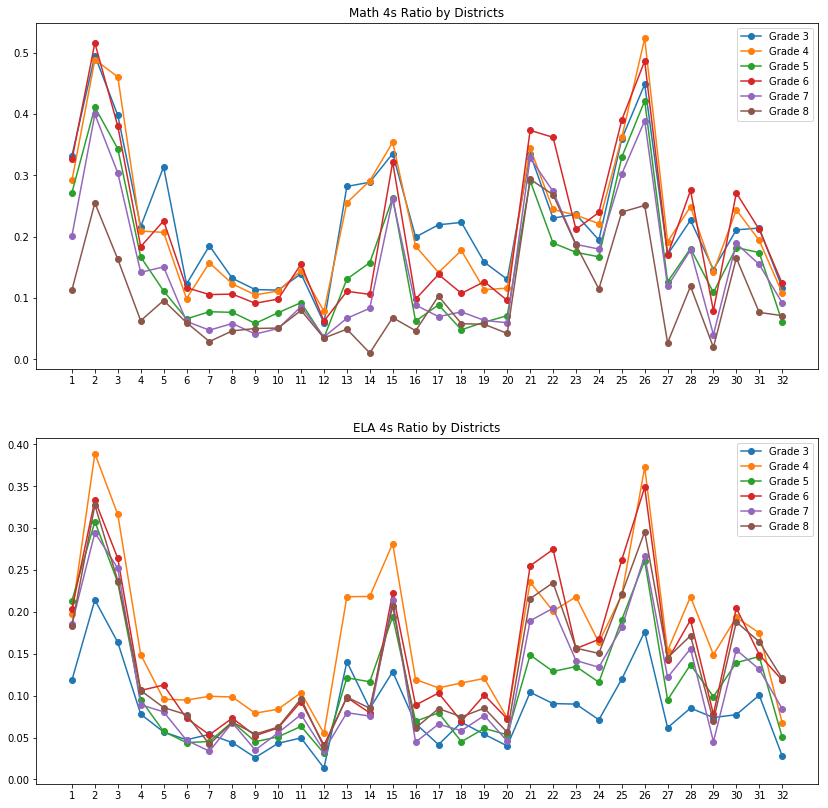

In [18]:
grade_list = ['Grade 3','Grade 4','Grade 5','Grade 6','Grade 7','Grade 8']

fig,ax = plt.subplots(nrows=2, figsize=(14,14))

for i in range(6):
    ax[1].plot(range(1,33),ela4s_ratio.iloc[:,i],'-o',label=grade_list[i])
    ax[0].plot(range(1,33),math4s_ratio.iloc[:,i],'-o',label=grade_list[i])
    
for i in range(2):
    ax[i].legend(); ax[i].set_xticks(list(range(1,33)))
ax[0].set_title('Math 4s Ratio by Districts'); ax[1].set_title('ELA 4s Ratio by Districts');

In [19]:
list(d5_shsat_2016.iloc[:,[20,40,60,80,100,120]].columns)

['Grade 3 ELA 4s - All Students',
 'Grade 4 ELA 4s - All Students',
 'Grade 5 ELA 4s - All Students',
 'Grade 6 ELA 4s - All Students',
 'Grade 7 ELA 4s - All Students',
 'Grade 8 ELA 4s - All Students']

In [20]:
ela4s_ratio2 = pd.DataFrame({
    'Grade 3': d5_shsat_2016.iloc[:,20]/ d5_shsat_2016.iloc[:,19],
    'Grade 4': d5_shsat_2016.iloc[:,40]/ d5_shsat_2016.iloc[:,39],
    'Grade 5': d5_shsat_2016.iloc[:,60]/ d5_shsat_2016.iloc[:,59],
    'Grade 6': d5_shsat_2016.iloc[:,80]/ d5_shsat_2016.iloc[:,79],
    'Grade 7': d5_shsat_2016.iloc[:,100]/ d5_shsat_2016.iloc[:,99],
    'Grade 8': d5_shsat_2016.iloc[:,120]/ d5_shsat_2016.iloc[:,119]
})
math4s_ratio2 = pd.DataFrame({
    'Grade 3': d5_shsat_2016.iloc[:,30]/ d5_shsat_2016.iloc[:,29],
    'Grade 4': d5_shsat_2016.iloc[:,50]/ d5_shsat_2016.iloc[:,49],
    'Grade 5': d5_shsat_2016.iloc[:,70]/ d5_shsat_2016.iloc[:,69],
    'Grade 6': d5_shsat_2016.iloc[:,90]/ d5_shsat_2016.iloc[:,89],
    'Grade 7': d5_shsat_2016.iloc[:,110]/ d5_shsat_2016.iloc[:,109],
    'Grade 8': d5_shsat_2016.iloc[:,130]/ d5_shsat_2016.iloc[:,129]
})
ela4s_ratio2 = ela4s_ratio2.fillna(0)
math4s_ratio2 = math4s_ratio2.fillna(0)
ela4s_ratio2.shape, math4s_ratio2.shape

((21, 6), (21, 6))

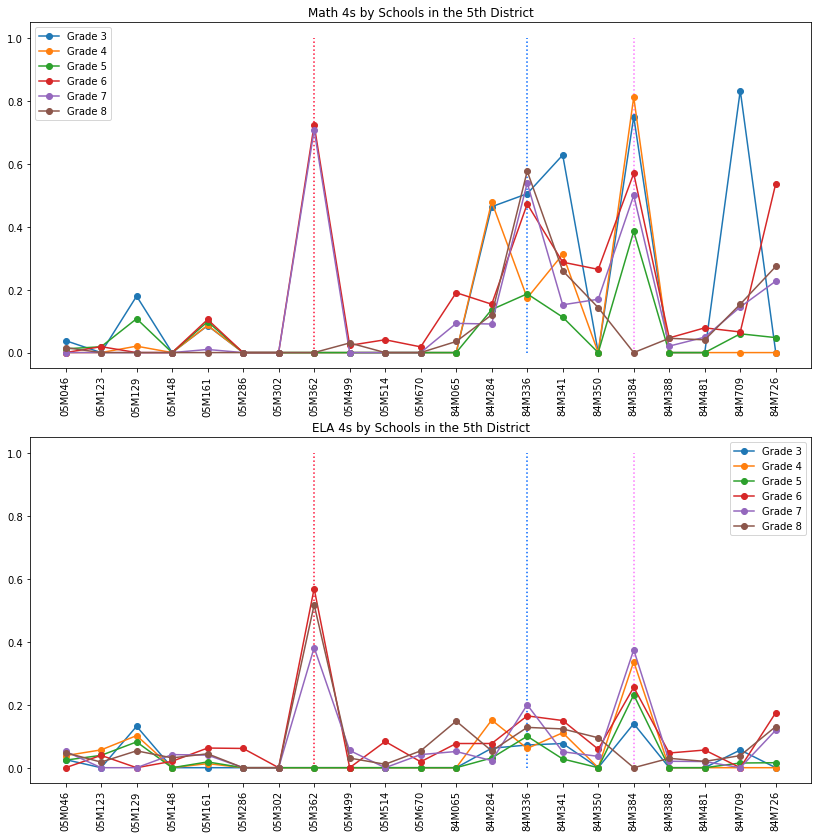

In [23]:
fig,ax = plt.subplots(nrows=2, figsize=(14,14))

for i in range(6):
    ax[1].plot(range(1,22),ela4s_ratio2.iloc[:,i],'-o',label=grade_list[i])
    ax[0].plot(range(1,22),math4s_ratio2.iloc[:,i],'-o',label=grade_list[i])
    
for i in range(2):
    ax[i].legend(); 
    ax[i].set_xticks(range(1,22))
    ax[i].set_xticklabels(list(d5_shsat_2016['Location Code']),
                   rotation=90)
    ax[i].vlines(8,0,1,linestyle="dotted",color='#fd0e35') 
    ax[i].vlines(14,0,1,linestyle="dotted",color='#0066ff')
    ax[i].vlines(17,0,1,linestyle="dotted",color='#fc74fd')
ax[0].set_title('Math 4s by Schools in the 5th District') 
ax[1].set_title('ELA 4s by Schools in the 5th District');

During assessing the ratio of the number of students with excellent scores to the number of tested students, the same leaders are identified among schools.

#### Discipline

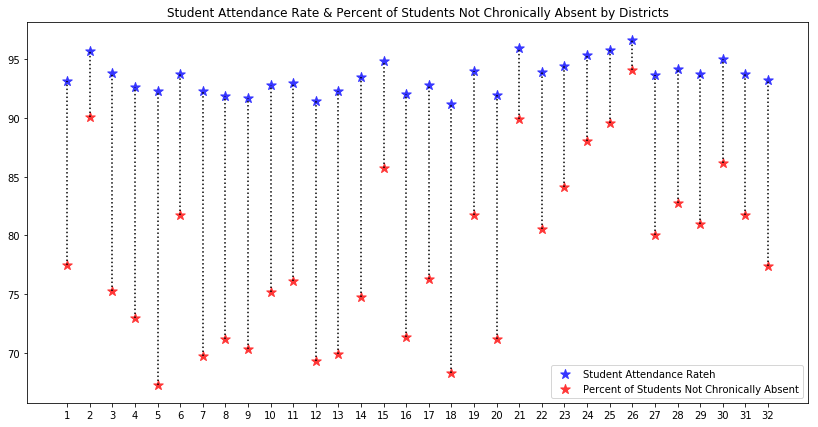

In [24]:
fig,ax = plt.subplots(1, figsize=(14,7))

ax.scatter(range(1,33),districts['Student Attendance Rate'].drop([10]),
           marker='*',s=100,label='Student Attendance Rateh',c='#3636ff')
ax.scatter(range(1,33),100-districts['Percent of Students Chronically Absent'].drop([10]),
           marker='*',s=100,label='Percent of Students Not Chronically Absent',c='#ff3636')
plt.vlines(range(1,33),
           100-districts['Percent of Students Chronically Absent'].drop([10]),
           districts['Student Attendance Rate'].drop([10]),
           linestyle="dotted")
ax.legend()
ax.set_xticks(list(range(1,33)))
plt.title('Student Attendance Rate & Percent of Students Not Chronically Absent by Districts');

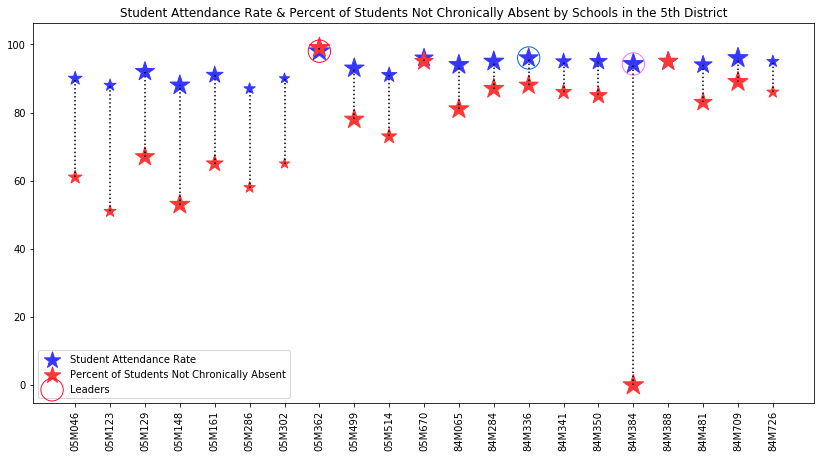

In [29]:
fig,ax = plt.subplots(1, figsize=(14,7))

ax.scatter(range(1,22),d5_shsat_2016['Student Attendance Rate'],
           marker='*',s=took*500,label='Student Attendance Rate',c='#3636ff')
ax.scatter(range(1,22),100-d5_shsat_2016['Percent of Students Chronically Absent'],
           marker='*',s=took*500,label='Percent of Students Not Chronically Absent',c='#ff3636')
plt.vlines(range(1,22),
           100-d5_shsat_2016['Percent of Students Chronically Absent'],
           d5_shsat_2016['Student Attendance Rate'],
           linestyle="dotted")

ax.scatter([8,14,17],d5_shsat_2016['Student Attendance Rate'][[7,13,16]],label='Leaders',
           s=500,facecolors='none',edgecolors=['#fd0e35','#0066ff','#fc74fd'])
ax.legend(loc=3)
ax.set_xticks(range(1,22))
ax.set_xticklabels(list(d5_shsat_2016['Location Code']),
                   rotation=90)
plt.title('Student Attendance Rate & Percent of Students Not Chronically Absent by Schools in the 5th District');

Three leaders among schools also have a good level of attendance. 

The outlier point looks like a mistake in the data set.

#### 4S Results of the Economically Disadvantaged Category among All 4S Results

In [30]:
ela4s_ratio_ed = pd.DataFrame({
    'Grade 3': districts.iloc[:,31].drop([10])/ districts.iloc[:,23].drop([10]),
    'Grade 4': districts.iloc[:,51].drop([10])/ districts.iloc[:,43].drop([10]),
    'Grade 5': districts.iloc[:,71].drop([10])/ districts.iloc[:,63].drop([10]),
    'Grade 6': districts.iloc[:,91].drop([10])/ districts.iloc[:,83].drop([10]),
    'Grade 7': districts.iloc[:,111].drop([10])/ districts.iloc[:,103].drop([10]),
    'Grade 8': districts.iloc[:,131].drop([10])/ districts.iloc[:,123].drop([10])
})
math4s_ratio_ed = pd.DataFrame({
    'Grade 3': districts.iloc[:,41].drop([10])/ districts.iloc[:,33].drop([10]),
    'Grade 4': districts.iloc[:,61].drop([10])/ districts.iloc[:,53].drop([10]),
    'Grade 5': districts.iloc[:,81].drop([10])/ districts.iloc[:,73].drop([10]),
    'Grade 6': districts.iloc[:,101].drop([10])/ districts.iloc[:,93].drop([10]),
    'Grade 7': districts.iloc[:,121].drop([10])/ districts.iloc[:,113].drop([10]),
    'Grade 8': districts.iloc[:,141].drop([10])/ districts.iloc[:,133].drop([10])
})
ela4s_ratio_ed.shape, math4s_ratio_ed.shape

((32, 6), (32, 6))

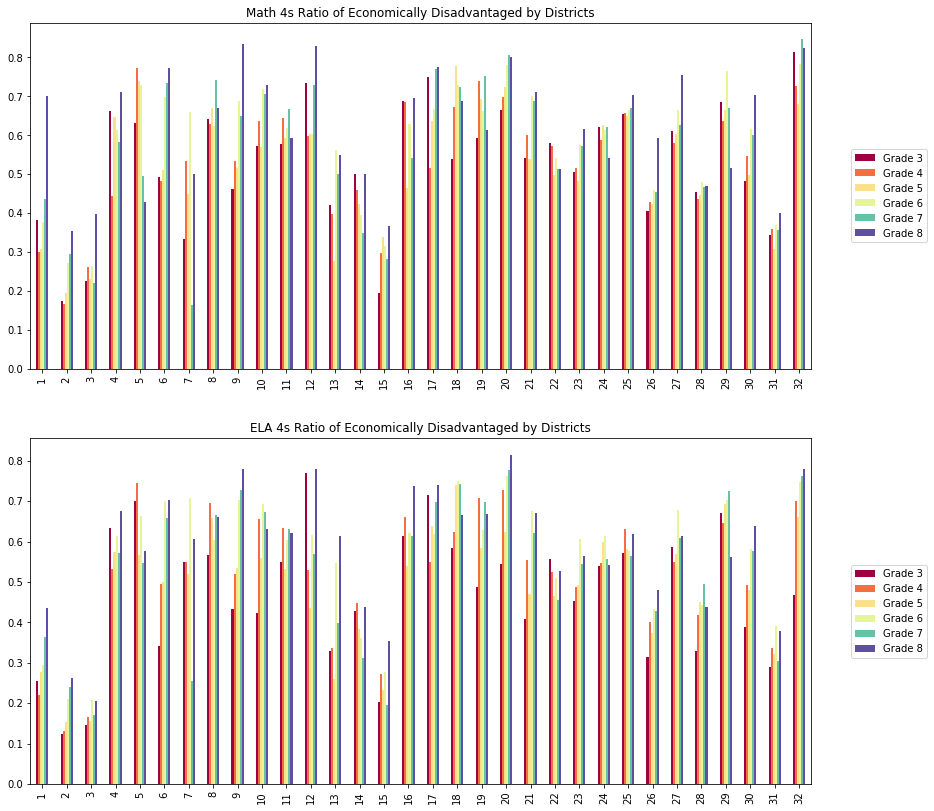

In [64]:
fig,ax = plt.subplots(nrows=2, figsize=(14,14))

ela4s_ratio_ed.plot.bar(ax=ax[1],cmap=cm.Spectral)
math4s_ratio_ed.plot.bar(ax=ax[0],cmap=cm.Spectral);
    
for i in range(2):
    ax[i].legend(loc=10, bbox_to_anchor=(1.1,0.5))
    ax[i].set_xticklabels(list(range(1,33)))
    
ax[0].set_title('Math 4s Ratio of Economically Disadvantaged by Districts') 
ax[1].set_title('ELA 4s Ratio of Economically Disadvantaged by Districts');

In [32]:
ela4s_ratio_ed2 = pd.DataFrame({
    'Grade 3': d5_shsat_2016.iloc[:,28]/ d5_shsat_2016.iloc[:,20],
    'Grade 4': d5_shsat_2016.iloc[:,48]/ d5_shsat_2016.iloc[:,40],
    'Grade 5': d5_shsat_2016.iloc[:,68]/ d5_shsat_2016.iloc[:,60],
    'Grade 6': d5_shsat_2016.iloc[:,88]/ d5_shsat_2016.iloc[:,80],
    'Grade 7': d5_shsat_2016.iloc[:,108]/ d5_shsat_2016.iloc[:,100],
    'Grade 8': d5_shsat_2016.iloc[:,128]/ d5_shsat_2016.iloc[:,120]
})
math4s_ratio_ed2 = pd.DataFrame({
    'Grade 3': d5_shsat_2016.iloc[:,38]/ d5_shsat_2016.iloc[:,30],
    'Grade 4': d5_shsat_2016.iloc[:,58]/ d5_shsat_2016.iloc[:,50],
    'Grade 5': d5_shsat_2016.iloc[:,78]/ d5_shsat_2016.iloc[:,70],
    'Grade 6': d5_shsat_2016.iloc[:,98]/ d5_shsat_2016.iloc[:,90],
    'Grade 7': d5_shsat_2016.iloc[:,118]/ d5_shsat_2016.iloc[:,110],
    'Grade 8': d5_shsat_2016.iloc[:,138]/ d5_shsat_2016.iloc[:,130]
})
ela4s_ratio_ed2 = ela4s_ratio_ed2.fillna(0)
math4s_ratio_ed2 = math4s_ratio_ed2.fillna(0)
ela4s_ratio_ed2.shape, math4s_ratio_ed2.shape

((21, 6), (21, 6))

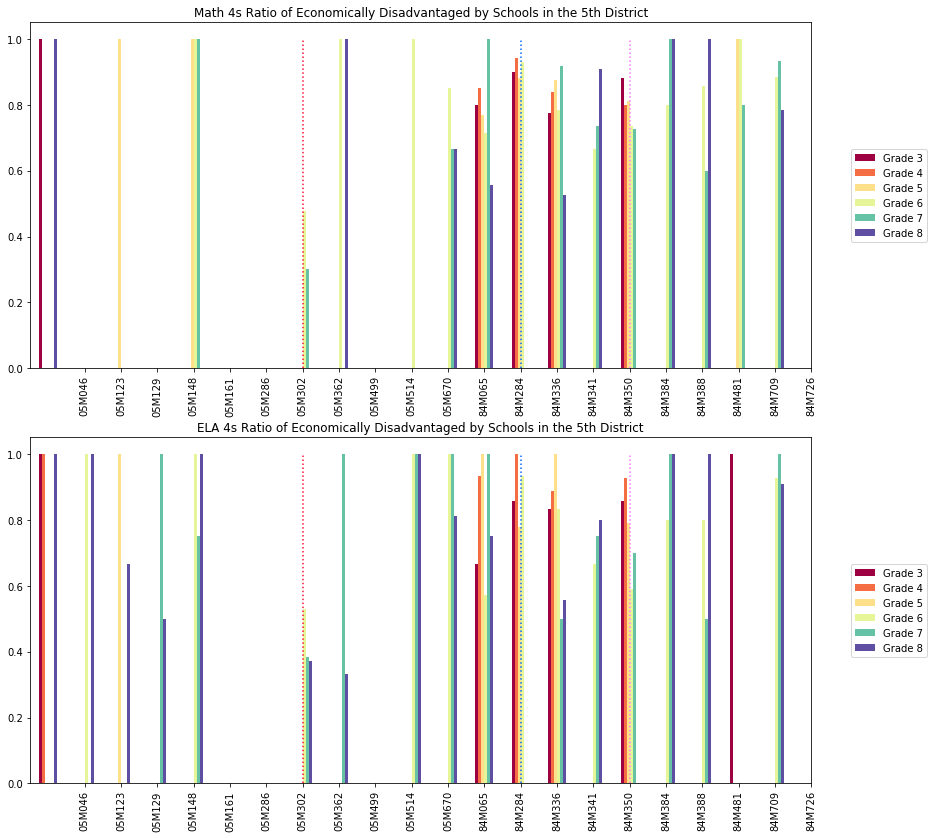

In [65]:
fig,ax = plt.subplots(nrows=2, figsize=(14,14))

math4s_ratio_ed2.plot.bar(ax=ax[0],cmap=cm.Spectral)
ela4s_ratio_ed2.plot.bar(ax=ax[1],cmap=cm.Spectral)
    
for i in range(2):
    ax[i].legend(loc=10, bbox_to_anchor=(1.1,0.5))
    ax[i].set_xticks(range(1,22))
    ax[i].set_xticklabels(list(d5_shsat_2016['Location Code']),
                          rotation=90)
    ax[i].vlines(7,0,1,linestyle="dotted",color='#fd0e35')
    ax[i].vlines(13,0,1,linestyle="dotted",color='#0066ff')
    ax[i].vlines(16,0,1,linestyle="dotted",color='#fc74fd')
    
ax[0].set_title('Math 4s Ratio of Economically Disadvantaged by Schools in the 5th District') 
ax[1].set_title('ELA 4s Ratio of Economically Disadvantaged by Schools in the 5th District');

Two of three mentioned leaders has high test results of all levels for this category of students. 

#### 4S Results of the Limited English Proficient Category among All 4S Results

In [35]:
ela4s_ratio_le = pd.DataFrame({
    'Grade 3': districts.iloc[:,30].drop([10])/ districts.iloc[:,23].drop([10]),
    'Grade 4': districts.iloc[:,50].drop([10])/ districts.iloc[:,43].drop([10]),
    'Grade 5': districts.iloc[:,70].drop([10])/ districts.iloc[:,63].drop([10]),
    'Grade 6': districts.iloc[:,90].drop([10])/ districts.iloc[:,83].drop([10]),
    'Grade 7': districts.iloc[:,110].drop([10])/ districts.iloc[:,103].drop([10]),
    'Grade 8': districts.iloc[:,130].drop([10])/ districts.iloc[:,123].drop([10])
})
math4s_ratio_le = pd.DataFrame({
    'Grade 3': districts.iloc[:,40].drop([10])/ districts.iloc[:,33].drop([10]),
    'Grade 4': districts.iloc[:,60].drop([10])/ districts.iloc[:,53].drop([10]),
    'Grade 5': districts.iloc[:,80].drop([10])/ districts.iloc[:,73].drop([10]),
    'Grade 6': districts.iloc[:,100].drop([10])/ districts.iloc[:,93].drop([10]),
    'Grade 7': districts.iloc[:,120].drop([10])/ districts.iloc[:,113].drop([10]),
    'Grade 8': districts.iloc[:,140].drop([10])/ districts.iloc[:,133].drop([10])
})
ela4s_ratio_le.shape, math4s_ratio_le.shape

((32, 6), (32, 6))

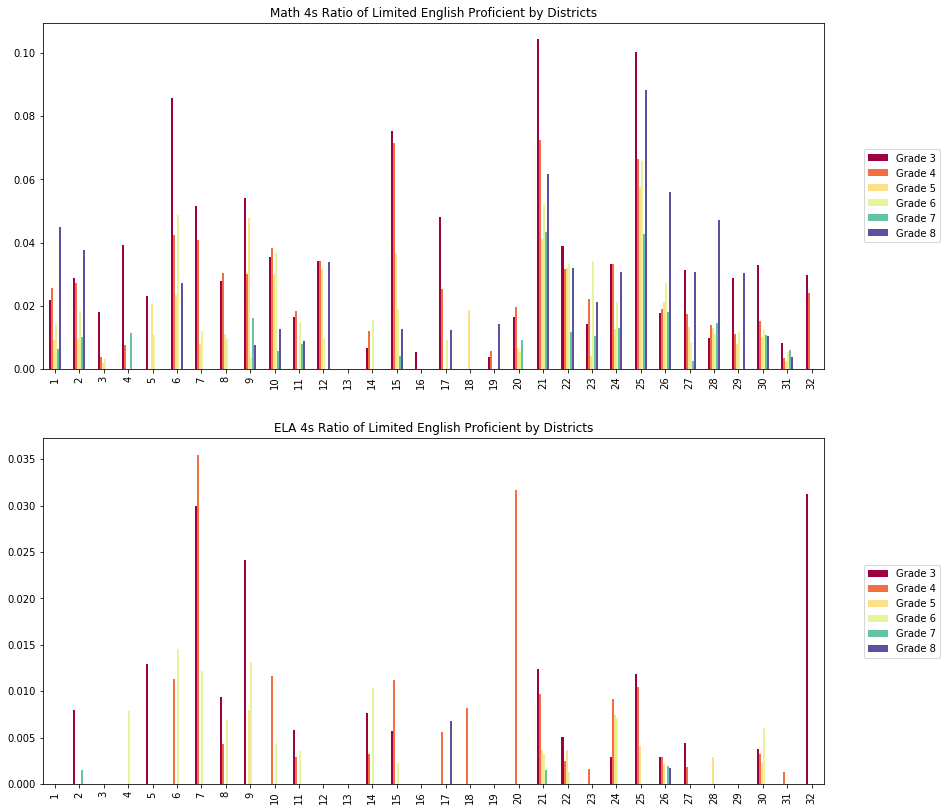

In [50]:
fig,ax = plt.subplots(nrows=2, figsize=(14,14))

math4s_ratio_le.plot.bar(ax=ax[0],cmap=cm.Spectral)
ela4s_ratio_le.plot.bar(ax=ax[1],cmap=cm.Spectral)
    
for i in range(2):
    ax[i].legend(loc=10, bbox_to_anchor=(1.1,0.5)) 
    ax[i].set_xticklabels(list(range(1,33)))
    
ax[0].set_title('Math 4s Ratio of Limited English Proficient by Districts') 
ax[1].set_title('ELA 4s Ratio of Limited English Proficient by Districts');

In [37]:
ela4s_ratio_le2 = pd.DataFrame({
    'Grade 3': d5_shsat_2016.iloc[:,27]/ d5_shsat_2016.iloc[:,20],
    'Grade 4': d5_shsat_2016.iloc[:,47]/ d5_shsat_2016.iloc[:,40],
    'Grade 5': d5_shsat_2016.iloc[:,67]/ d5_shsat_2016.iloc[:,60],
    'Grade 6': d5_shsat_2016.iloc[:,87]/ d5_shsat_2016.iloc[:,80],
    'Grade 7': d5_shsat_2016.iloc[:,107]/ d5_shsat_2016.iloc[:,100],
    'Grade 8': d5_shsat_2016.iloc[:,127]/ d5_shsat_2016.iloc[:,120]
})
math4s_ratio_le2 = pd.DataFrame({
    'Grade 3': d5_shsat_2016.iloc[:,37]/ d5_shsat_2016.iloc[:,30],
    'Grade 4': d5_shsat_2016.iloc[:,57]/ d5_shsat_2016.iloc[:,50],
    'Grade 5': d5_shsat_2016.iloc[:,77]/ d5_shsat_2016.iloc[:,70],
    'Grade 6': d5_shsat_2016.iloc[:,97]/ d5_shsat_2016.iloc[:,90],
    'Grade 7': d5_shsat_2016.iloc[:,117]/ d5_shsat_2016.iloc[:,110],
    'Grade 8': d5_shsat_2016.iloc[:,137]/ d5_shsat_2016.iloc[:,130]
})
ela4s_ratio_le2 = ela4s_ratio_le2.fillna(0)
math4s_ratio_le2 = math4s_ratio_le2.fillna(0)
ela4s_ratio_le2.shape, math4s_ratio_le2.shape

((21, 6), (21, 6))

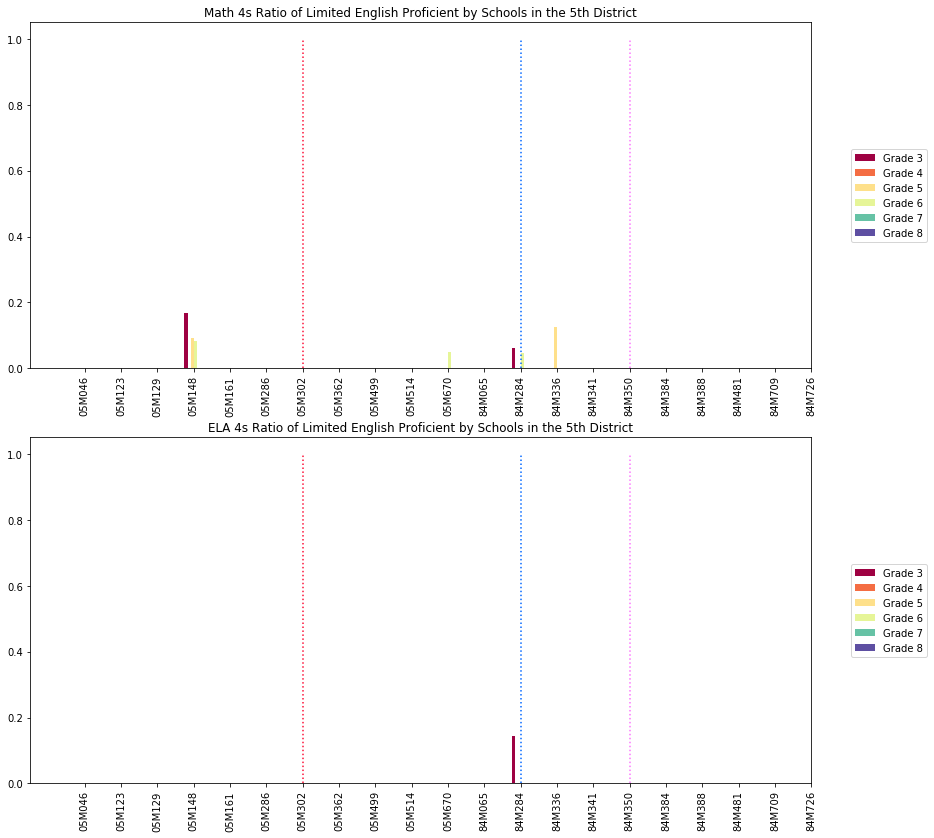

In [49]:
fig,ax = plt.subplots(nrows=2, figsize=(14,14))

math4s_ratio_le2.plot.bar(ax=ax[0],cmap=cm.Spectral)
ela4s_ratio_le2.plot.bar(ax=ax[1],cmap=cm.Spectral)
    
for i in range(2):
    ax[i].legend(loc=10, bbox_to_anchor=(1.1,0.5))
    ax[i].set_xticks(list(range(1,22)))
    ax[i].set_xticklabels(list(d5_shsat_2016['Location Code']),
                          rotation=90)
    ax[i].vlines(7,0,1,linestyle="dotted",color='#fd0e35')
    ax[i].vlines(13,0,1,linestyle="dotted",color='#0066ff')
    ax[i].vlines(16,0,1,linestyle="dotted",color='#fc74fd')
    
ax[0].set_title('Math 4s Ratio of Limited English Proficient by Schools in the 5th District') 
ax[1].set_title('ELA 4s Ratio of Limited English Proficient by Schools in the 5th District');

A huge difference is visible in the results of two types of testing (Math & ELA) for this category. 

In addition, and the 5th District is characterized by a small number of successful students in this category.

At the same time, it looks like one of the leaders has a great experience for ELL students. 

## &#x1F310; &nbsp; Economic Indicator Visualization

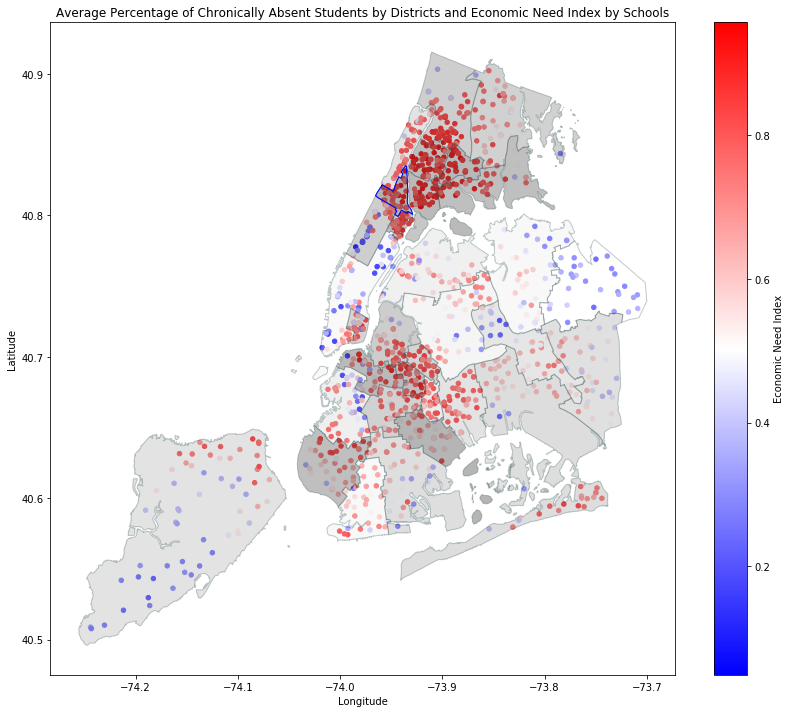

In [40]:
fig,ax = plt.subplots(1, figsize=(14,12))
school_explorer.plot(kind='scatter',x='Longitude',y='Latitude',ax=ax,
                     s=20,c='Economic Need Index',cmap=cm.bwr)
ax.add_patch(PolygonPatch(districts.geometry[4], fc='none', ec='b', zorder=2 ))
districts.plot(ax=ax, column='Percent of Students Chronically Absent', 
               cmap='Greys', alpha=0.3, edgecolor='darkslategray')
plt.title('Average Percentage of Chronically Absent Students by Districts \
and Economic Need Index by Schools');

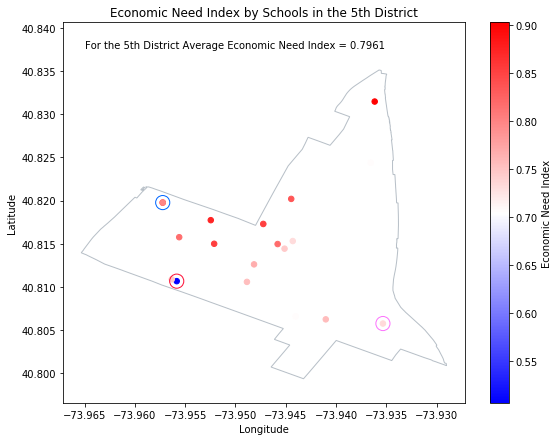

In [42]:
fig = plt.figure(figsize=(9,7)) 
ax = fig.gca() 
ax.add_patch(PolygonPatch(districts.geometry[4],
                          fc='none',ec='slategray', 
                          alpha=0.5,zorder=2 ))
d5_shsat_2016.plot(kind='scatter',x='Longitude',y='Latitude',ax=ax,
                   s=30,c='Economic Need Index',cmap=cm.bwr)
ax.scatter(d5_shsat_2016['Longitude'][[7,13,16]],
           d5_shsat_2016['Latitude'][[7,13,16]],
           s=200,facecolors='none',edgecolors=['#fd0e35','#0066ff','#fc74fd'])
ax.text(-73.965,40.8377,
        'For the 5th District Average Economic Need Index = '+\
        str(round(districts['Economic Need Index'][4],4)))
plt.title('Economic Need Index by Schools in the 5th District');

In [43]:
def highlight(df):
    if df['Economic Need Index'] < 0.6:
        return ['background-color: #fd0e35']
    elif df['Economic Need Index'] > 0.79:
        return ['background-color: #0066ff']
    else:
        return ['background-color: #fc74fd']
pd.DataFrame(d5_shsat_2016['Economic Need Index'].loc[[7,13,16]])\
.set_index([d5_shsat_2016['Location Code'].loc[[7,13,16]]])\
.style.apply(highlight, axis=1)

,Economic Need Index
Location Code,
05M362,0.507
84M336,0.798
84M384,0.734


Three leaders among schools in the 5th District have the certain difference with another one in the economic situation.

## &#x1F310; &nbsp;  Tendency 2010 -> 2012 -> 2016
#### Usage the Same Systems of Measuring

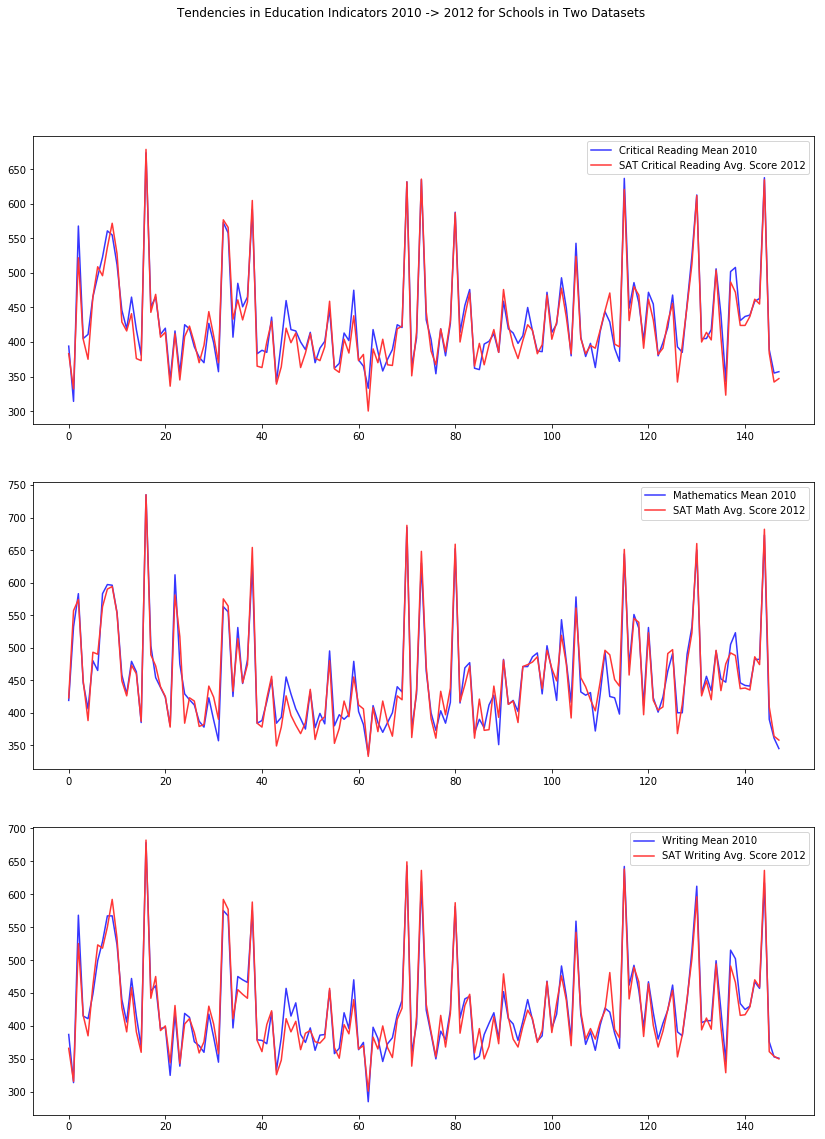

In [47]:
fig,ax = plt.subplots(nrows=3, figsize=(14,18))
plt.suptitle('Tendencies in Education Indicators 2010 -> 2012 for Schools in Two Datasets')

tend_list1 = ['Critical Reading Mean 2010', 
              'SAT Critical Reading Avg. Score 2012']
tend_list2 = ['Mathematics Mean 2010',
              'SAT Math Avg. Score 2012']
tend_list3 = ['Writing Mean 2010',
              'SAT Writing Avg. Score 2012']
res_2010_2012[tend_list1].plot(ax=ax[0],color=['#3636ff','#ff3636'])
res_2010_2012[tend_list2].plot(ax=ax[1],color=['#3636ff','#ff3636'])
res_2010_2012[tend_list3].plot(ax=ax[2],color=['#3636ff','#ff3636']);

Such a graphic comparison allows identifying deterioration or improvement in the indicators of the region in general and in each individual school.

#### Usage the Different Systems of Measuring

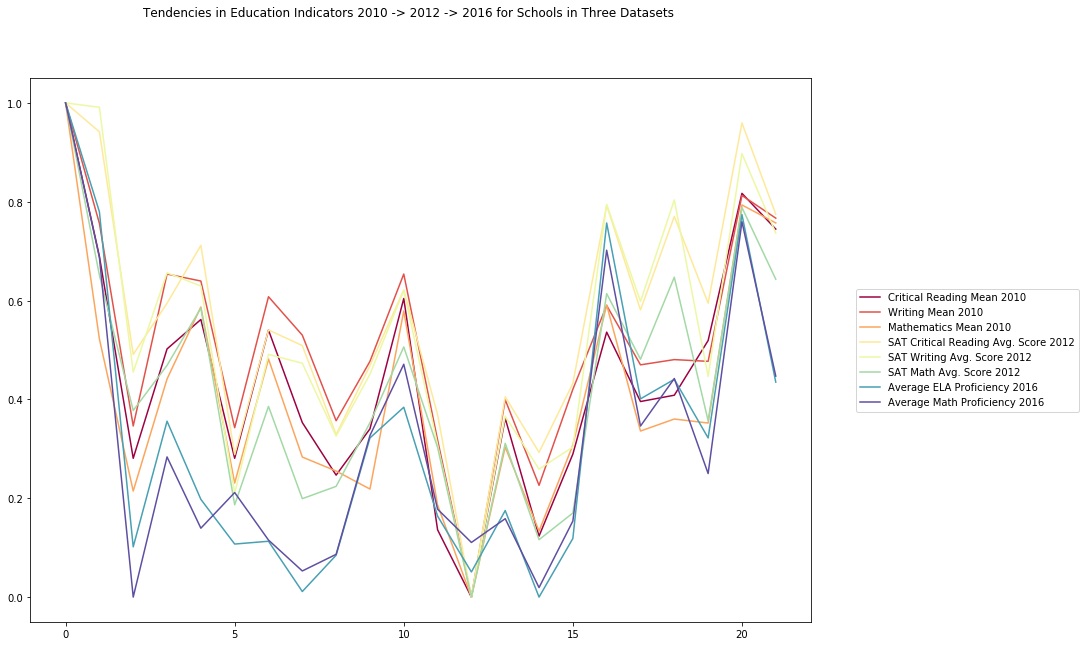

In [66]:
fig = plt.figure(figsize=(14,10)) 
ax = fig.gca()

plt.suptitle('Tendencies in Education Indicators 2010 -> 2012 -> 2016 for Schools in Three Datasets')
tend_list = ['Critical Reading Mean 2010', 
             'Writing Mean 2010',
             'Mathematics Mean 2010',
             'SAT Critical Reading Avg. Score 2012',
             'SAT Writing Avg. Score 2012',
             'SAT Math Avg. Score 2012',
             'Average ELA Proficiency 2016',
             'Average Math Proficiency 2016']

norm_res_2010_2012_2016[tend_list].plot(ax=ax,cmap=cm.Spectral)
ax.legend(loc=10, bbox_to_anchor=(1.2,0.5));

When the indicators and the measuring system were transformed, the comparison can be made by scaling on the segment [0;1]. In this case, it is possible to assess how the success of each particular school has changed with respect to the situation in the region or in the district.

On the graph, we can see the tendency in 2016 moving down in scaled indicators. It needs to find out is it the real failure or it's just because of changing the measuring system.